In [1]:
# Import Bibliotek
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [2]:
# 2.  Read dataset. 
df=pd.read_csv("BTC-USD2.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-20,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,88281943359
1,2021-05-21,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,82051616861
2,2021-05-22,37371.031250,38831.054688,35383.683594,37536.632813,37536.632813,57377273240
3,2021-05-23,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,78469274361
4,2021-05-24,34700.363281,39835.140625,34551.082031,38705.980469,38705.980469,67359584098


Text(0.5, 0, 'Date')

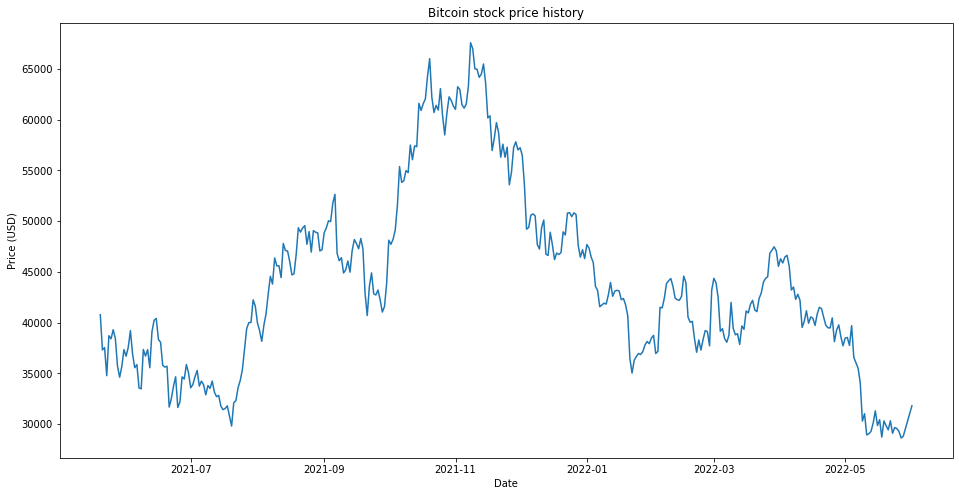

In [3]:
# 3. Analyze the closing prices from dataframe:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
plt.title('Bitcoin stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Date')

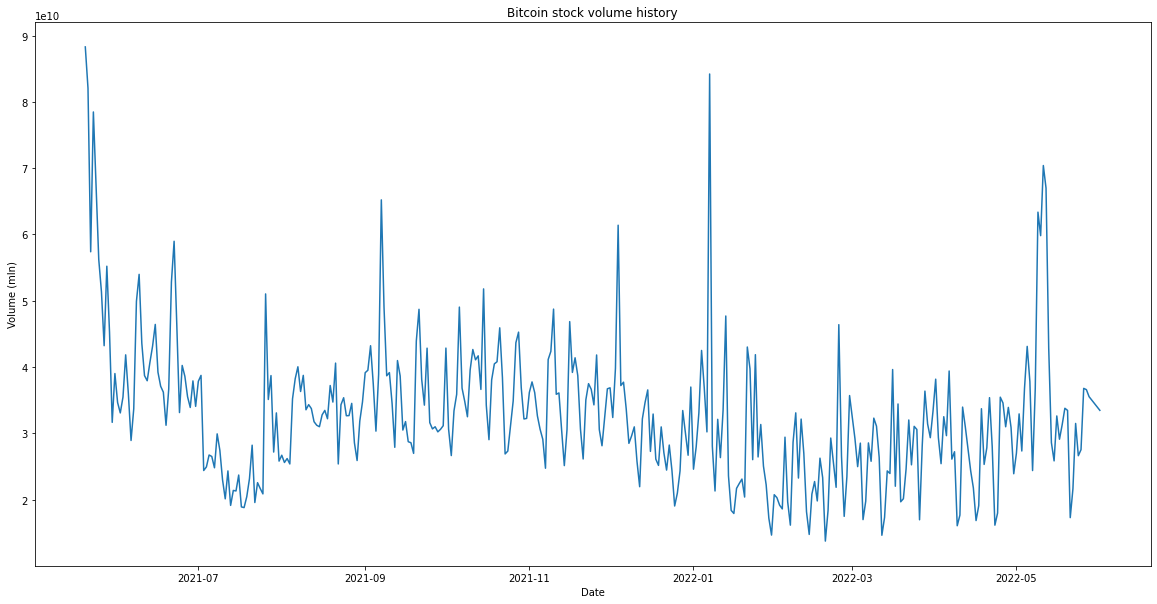

In [4]:
# Now let’s check out the plot for volume :
plt.plot(df["Volume"])
plt.title('Bitcoin stock volume history')
plt.ylabel('Volume (mln)')
plt.xlabel('Date')
plt.show()

In [5]:
#Now let’s see if we have any null/Nan values to worry about. 
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
# 4. Sort the dataset on date time and filter “Date” and “Close” columns:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
 
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    
# 5. Normalize the new filtered dataset:
# Minmaxscaler is the Python object, that is used for
# normalising our data inside a defined range (like 0-1).
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

# train_data=final_dataset[0:1793,:]  # dataset BTC-USD.csv(6 year)
# valid_data=final_dataset[1793:,:]
train_data=final_dataset[0:279,:]      # dataset BTC-USD2.csv (1year)
valid_data=final_dataset[279:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)    


print(new_dataset.shape)

(375, 1)


In [7]:
new_dataset.head()

,Close
Date,
2021-05-20,40782.738281
2021-05-21,37304.691406
2021-05-22,37536.632813
2021-05-23,34770.582031
2021-05-24,38705.980469


In [8]:
print(train_data.shape)

(279, 1)


In [9]:
# Reshape data from 2D to 3D  
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

print(x_train_data.shape)

(219, 60, 1)


In [10]:
print(x_train_data)

[[[0.31215709]
  [0.22283727]
  [0.22879377]
  ...
  [0.07175188]
  [0.07461607]
  [0.08138924]]

 [[0.22283727]
  [0.22879377]
  [0.15775874]
  ...
  [0.07461607]
  [0.08138924]
  [0.05624807]]

 [[0.22879377]
  [0.15775874]
  [0.25882382]
  ...
  [0.08138924]
  [0.05624807]
  [0.03029779]]

 ...

 [[0.5136446 ]
  [0.56901359]
  [0.56998065]
  ...
  [0.30587226]
  [0.29285107]
  [0.29519266]]

 [[0.56901359]
  [0.56998065]
  [0.55990506]
  ...
  [0.29285107]
  [0.29519266]
  [0.25177177]]

 [[0.56998065]
  [0.55990506]
  [0.56965502]
  ...
  [0.29519266]
  [0.25177177]
  [0.21694579]]]


In [11]:

# 6. Build and train the LSTM model/Units-50 LSTM with 50 neurons-basically means that the dimension of the output vector, h, is 50.
lstm_model=Sequential()
lstm_model.add(LSTM(units=32,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
# lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64))
# lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
hystory=lstm_model.fit(x_train_data,y_train_data,epochs=40,batch_size=8,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

print(lstm_model.summary())

Epoch 1/40
28/28 - 8s - loss: 0.0421 - 8s/epoch - 300ms/step
Epoch 2/40
28/28 - 1s - loss: 0.0113 - 832ms/epoch - 30ms/step
Epoch 3/40
28/28 - 1s - loss: 0.0091 - 798ms/epoch - 28ms/step
Epoch 4/40
28/28 - 1s - loss: 0.0080 - 857ms/epoch - 31ms/step
Epoch 5/40
28/28 - 1s - loss: 0.0069 - 971ms/epoch - 35ms/step
Epoch 6/40
28/28 - 1s - loss: 0.0070 - 845ms/epoch - 30ms/step
Epoch 7/40
28/28 - 1s - loss: 0.0065 - 845ms/epoch - 30ms/step
Epoch 8/40
28/28 - 1s - loss: 0.0061 - 848ms/epoch - 30ms/step
Epoch 9/40
28/28 - 1s - loss: 0.0058 - 829ms/epoch - 30ms/step
Epoch 10/40
28/28 - 1s - loss: 0.0051 - 884ms/epoch - 32ms/step
Epoch 11/40
28/28 - 1s - loss: 0.0062 - 807ms/epoch - 29ms/step
Epoch 12/40
28/28 - 1s - loss: 0.0056 - 840ms/epoch - 30ms/step
Epoch 13/40
28/28 - 1s - loss: 0.0054 - 827ms/epoch - 30ms/step
Epoch 14/40
28/28 - 1s - loss: 0.0048 - 831ms/epoch - 30ms/step
Epoch 15/40
28/28 - 1s - loss: 0.0046 - 825ms/epoch - 29ms/step
Epoch 16/40
28/28 - 1s - loss: 0.0043 - 818ms/epoch

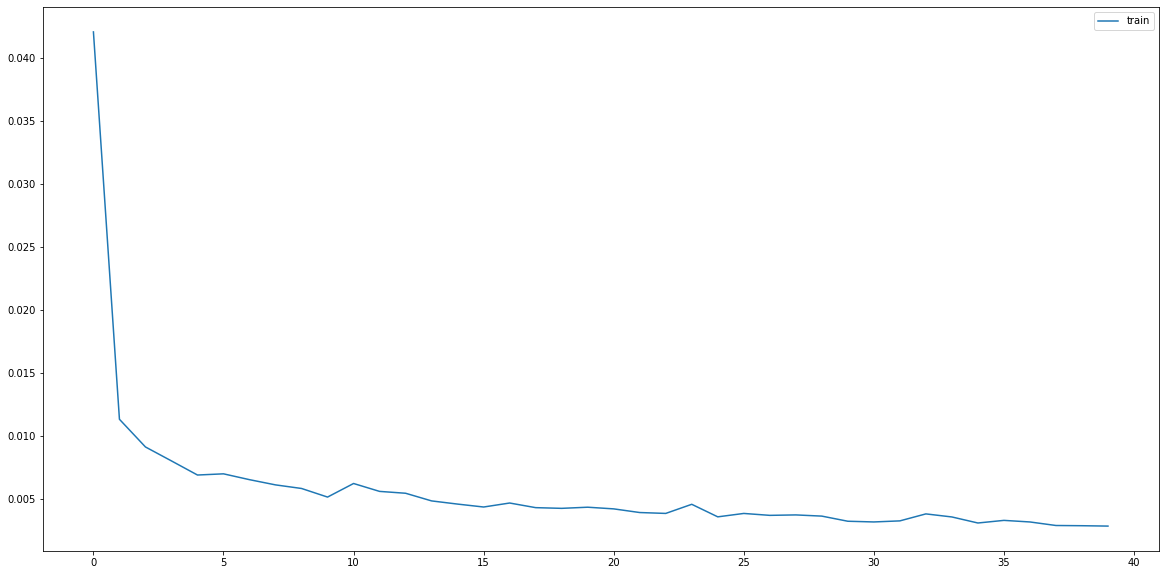

In [12]:
# Plot line graph to show amount loss according the the epoch
plt.plot(hystory.history['loss'], label='train')
# plt.plot(hystory.history['val_loss'], label='test')
plt.legend()
plt.show()
 

In [13]:
print("Number of weights after calling the model:", len(lstm_model.weights)) 

Number of weights after calling the model: 8


In [14]:
# Returns all the layers of the model as list.
lstm_model.layers


In [15]:
 # Returns all the input tensors of the model as list.
lstm_model.inputs

[<KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_input')>]

In [16]:
# − Returns all the output tensors of the model as list.
lstm_model.outputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>]

In [17]:
#If you want to get weights and biases of all layers, you can simply use:
for layer in lstm_model.layers: print(layer.get_config(), layer.get_weights())

{'name': 'lstm', 'trainable': True, 'batch_input_shape': (None, 60, 1), 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 32, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2} [array([[ 0.25523025,  0.0086506 , -0.13863917, -0.06119378,  0.09471605,
        -0.11375094, -0.19719954,  0.20861486,  0.06280712,  0.07265256,
         0.22192194, -0.

In [18]:
# 7. Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [19]:
# 8. Save the LSTM model:
lstm_model.save("saved_model.h5")

C:\Users\46735\AppData\Local\Temp\ipykernel_2316\2128810988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


Text(0.5, 0, 'Date')

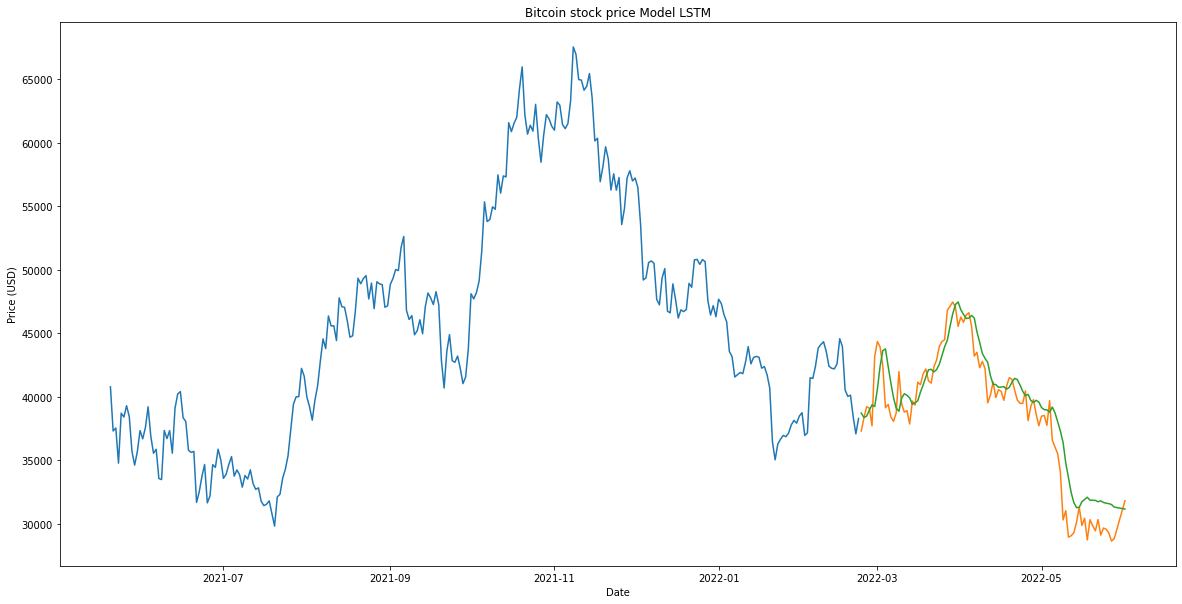

In [20]:

# 9. Visualize the predicted stock costs with actual stock costs:
train_data=new_dataset[:279]
valid_data=new_dataset[279:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.title('Bitcoin stock price Model LSTM')
plt.plot(valid_data[['Close',"Predictions"]])
plt.ylabel('Price (USD)')
plt.xlabel('Date')

In [21]:
#Future
# stateful=True
# future = []
# currentStep = predicted_closing_price[:,-1:,:] #last step from the previous prediction
# future_pred_count=
# for i in range(future_pred_count):
#     currentStep = lstm_model.predict(currentStep) #get the next step
#     future.append(currentStep) #store the future steps    

#after processing a sequence, reset the states for safety
# lstm_model.reset_states()